## ***Uncertainty Quantification***

Exercise 02 solution, 
May 06,2021


Prof. Dr. M.Frank


Dr. Jonas Kusch


Pia Stammer


Maqsood Rajput

----------------------------------------------------------------------------------------

Note: To render Jupyter Notebook and to run code on Bw-cloud instance, please sign up at https://e5188803.ka.bw-cloud-instance.org/ 

----------------------------------------------------------------------------------------

#### **EXERCISE SHEET 1**

In [1]:
import numpy as np
import sobol_seq
from pyDOE import *
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm

&nbsp;

**EXERCISE 1)**

Execute the following four sections:


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   a) In this section we compare different random numbers to approximate the value of  π . What does the code do exactly?

In [4]:
def generateSamples (N):
  samples=np.empty((N,2,5))
  labels=list()
  # MC
  samples[:,:,0]=np.random.uniform(0,1,(N,2))
  labels.append('Monte Carlo')

  # Latin hypercube
  samples[:,:,1]=lhs(2,samples=N,criterion="c")
  labels.append('Latin Hyp')

  # Halton Set
  halton_sample = tfp.mcmc.sample_halton_sequence(2, N,randomized=True, seed=127)
  samples[:,:,2] = halton_sample.numpy()
  labels.append('Halton')

  # Sobol Set
  samples[:,:,3]=sobol_seq.i4_sobol_generate(2, N)
  labels.append('Sobol')

  # Additive Recurrence
  alphax=np.random.uniform(0,1,(1,1))
  alphay=np.random.uniform(0,1,(1,1))
  x=np.cumsum(np.ones((N,1))*alphax)%1
  y=np.cumsum(np.ones((N,1))*alphay)%1
  samples[:,0,4]=x
  samples[:,1,4]=y
  labels.append('Additive rec')

  return [samples,labels]


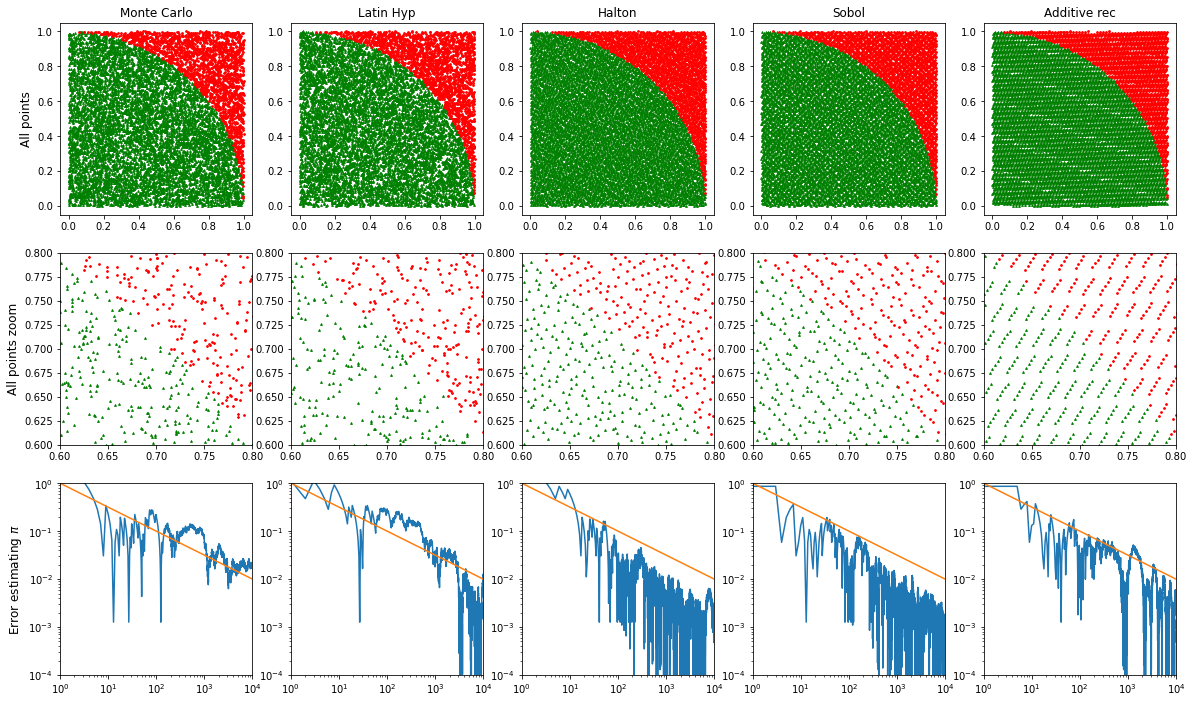

In [5]:
#Numbers of samples 
N=10000

#Generate samples
[samples,labels]=generateSamples(N)

K= np.size(samples,2)

#Check whether samples fall into unit circle
inside=np.empty((N,K),dtype=bool)

for k in range(K):
  inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)

#Plot results
fig, ax = plt.subplots(3,K,figsize=(4*K, 12))

for k in range(K):

  #label axes
  ax[0,k].set_title(labels[k])
  if k==0:
    ax[0,k].set_ylabel('All points', rotation=90, size='large')
    ax[1,k].set_ylabel('All points zoom', rotation=90, size='large')
    ax[2,k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')
    
  #Scatter samples and color according to position (in/outside circle)
  ax[0,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[0,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')

  #Show zoomed region (point structure)
  ax[1,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[1,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')
  ax[1,k].set_xlim([0.6, 0.8])
  ax[1,k].set_ylim([0.6, 0.8])

  #Show error convergence
  xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
  ax[2,k].loglog(abs(math.pi-4*xmean))
  ax[2,k].loglog(range(1,N+1),np.divide(1,np.sqrt(range(1,N+1))))
  ax[2,k].set_xlim([10**0, N])
  ax[2,k].set_ylim([1/N, 1])

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   b) What are we computing here? What happens if the number of batches tends towards infinity. How can you interpret the observations?

In [6]:
def giveError(N):

  #Generate samples
  [samples,labels]=generateSamples(N)
  K= np.size(samples,2)

  #Check whether samples fall into unit circle
  inside=np.empty((N,K),dtype=bool)
  error=np.empty((N,5))

  for k in range(K):
    inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)
    
    #Compute error
    xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
    error[:,k]= abs(math.pi-4*xmean)

  return error, labels

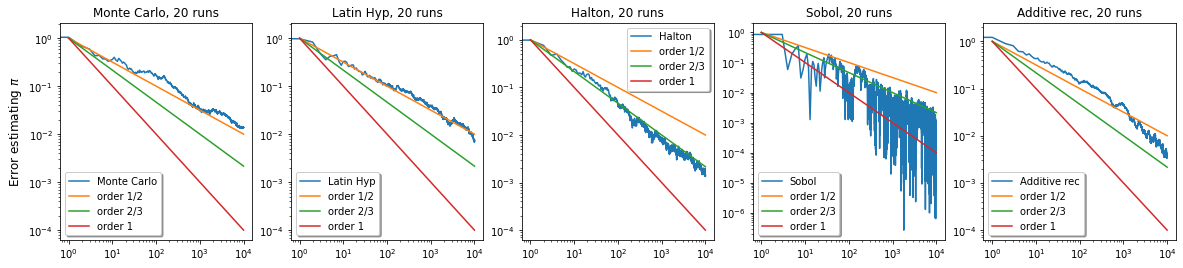

In [7]:
#Number of samples per batch
nSamples=10000

#Number of batches
nBatches=20

for i in range(nBatches):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  if i==0:
    [err , labels] = giveError(nSamples)
  else:
    err=err + giveError(nSamples)[0]

err = np.divide(err, nBatches)

#Plot results
fig, ax = plt.subplots(1,K,figsize=(4*K, 4))
for k in range(K):

  #label axes 
  ax[k].set_title("{0}, {1} runs".format(labels[k], nBatches))

  if k==0:
    ax[k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')

  ax[k].loglog(err[:,k],label=labels[k])
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.sqrt(range(1,nSamples+1))),label='order 1/2')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.arange(1,nSamples+1)**(2/3)),label='order 2/3')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,range(1,nSamples+1)),label='order 1')

  #label curves
  ax[k].legend(shadow=True, fancybox=True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   c) Interpret the graph created by c) and comment on random numbers vs. quasi random numbers (or Monte-Carlo vs. Quasi-Monte-Carlo).

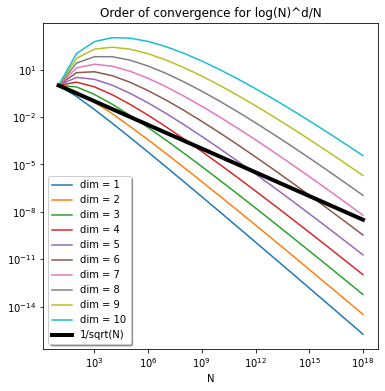

In [8]:
#Compute and plot log(N)^d/N for different values of N and d
toNormalize=True

N=10**np.arange(1,19)

plt.figure(figsize=(6,6))
for d in range(1,11):
  err=np.divide(np.log(N)**d,N)
  if toNormalize:
    err = np.divide(err,err[0])
  plt.loglog(N, err,label="dim = {0}".format(d))

err = np.divide(1,np.sqrt(N))

if toNormalize:
  err = np.divide(err, err[0])

plt.loglog(N,err,label="1/sqrt(N)", c="black",linewidth=4)
plt.title("Order of convergence for log(N)^d/N")
plt.xlabel("N")
_ = plt.legend(shadow=True, fancybox=True,loc='lower left')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   d) It is often said, that Monte-Carlo does not suffer from the Curse of dimensionality.          
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   How does this statement and the observations from d) fit together?

&nbsp; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   *Note: Don't worry if the graph doesn't appear immediately, computation can take a minute*

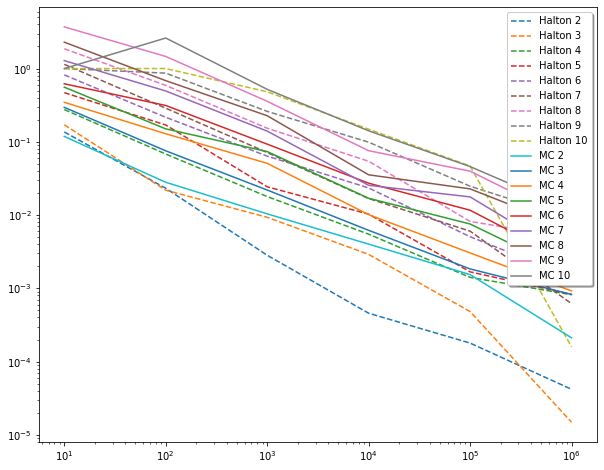

In [9]:
def volb1(dim):
  return math.pi**(dim/2)/math.gamma(dim/2 + 1)

volb= np.vectorize(volb1)

def volc(dim):
  return 2**dim
  
#Halton set

dim = 10
nSamples = 10**np.arange(1,7)
nBatches = 10
error = np.empty((np.size(nSamples),dim))

sample = tfp.mcmc.sample_halton_sequence(dim, num_results=nSamples[np.size(nSamples)-1],randomized=True, seed=127)
sample= sample.numpy()

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))

  for i in range(np.size(nSamples)):
    n=nSamples[i]
    inside = np.empty((n,dim),dtype=bool)
    r=np.random.randint(0,nSamples[np.size(nSamples)-1]-n+1)
    p=sample[r:r+n-1,:]
    # sequencer=ghalton.Halton(dim)
    # p= sequencer.get(10)
    # p=np.random.shuffle(p)
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)

plt.figure(figsize=(10,8))
for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="Halton {0}".format(d+1),linestyle='dashed')


 #Uniform random numbers

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  i=0
  for n in nSamples:
    inside = np.empty((n,dim),dtype=bool)
    p=np.random.uniform(0,1,(n,dim))
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    i = i+1

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)


for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="MC {0}".format(d+1))

_ = plt.legend(shadow=True, fancybox=True,loc='upper right')

&nbsp;

**EXERCISE 2)**

Consider the SIR-Model ([1]-[4]) for the spread of infectious diseases like the Corona virus.

The total population N is divided into the groups of **susceptible**, **infected** and **removed** (i.e. dead or recovered) individuals: 
**N = S + I + R**

&nbsp;

![alt text](https://drive.google.com/uc?export=view&id=1Cv8I_JHky6dLBO9JTobvYkKAaL9Qy0_X)

&nbsp;

The model assumes that
- every individual can only be infected once, then they are either immune or dead
- the categories dead and immune are summarized in the compartment "Removed"
- there is no incubation time
- the respective rates are constant


The following system of equations describes the flow of population between the three compartments

&nbsp;
$$ \frac{dS(t)}{dt} = - \beta S(t) I(t)$$

&nbsp;
$$ \frac{dI(t)}{dt} = \beta S(t) I(t) - \gamma I(t)$$

&nbsp;
$$ \frac{dR(t)}{dt} = \gamma I(t)$$

&nbsp;

$N(t)=N,\;\; S(t)\geq0,\;\; I(t)\geq0, \;\;R(t)\geq0$,

where the parameter $\beta$ represents the infection rate (number of infections per infected person per time unit (day)) and $\gamma$ represents the combined death and recovery rate (number of dead or recovered individuals per infectious person per day). 

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Derive a formula for the maximum number of infectious individuals depending on $\beta$ and $\gamma$.           
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;   How do $S(t), I(t) $and $R(t)$ behave for $t \rightarrow \infty$ ?

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  What can you say about the growth rate of infections?


&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Run the code below for different choices of $\beta$ and $\gamma$, how does the number of infections react?            
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Can you explain the development of the different curves for specific parameter choices? 


Reproduction Number = 0.9
Max. number of infections = 7358370.912021279


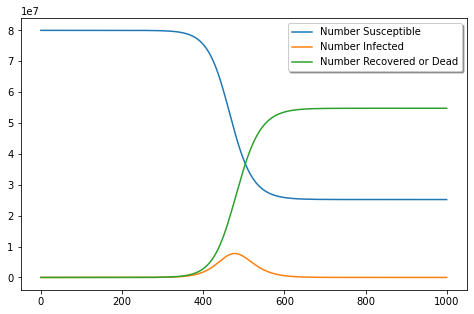

In [2]:
### (b) ###

#Set parameters
N = 80000000  #Population size
S_0 = N       #Number susceptible at time 0
I_0 = 1       #Number infected at time 0
R_0 = 0       #Number removed (recovered & immune or dead) at time 0

beta = 0.9/9/N          # number infections caused by one infected person per day
                        #(Currently in Germany, one person infects 0.9 other people while infectious (reproduction number) and is infectious for 8-10 days)
gamma = 0.0353 + 0.025  # death + recovery rate, number dead or recovered per day

t_0 = 0
t_end = 200            # timesteps
h=5                    # time step = h days

def f_S(I_t,S_t,beta):
  return -beta*I_t*S_t

def f_I(I_t,S_t,beta,gamma):
  return beta*S_t*I_t-gamma*I_t

def f_R(I_t,gamma):
  return gamma*I_t

def Euler (f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,T,beta,gamma):
  times = t_0 + np.arange(T+1)*h
  I=np.zeros(T+1,)
  I[0]=I_0

  S=np.zeros(T+1,)
  S[0]=S_0

  R=np.zeros(T+1,)
  R[0]=R_0
  
  for t in range(T):
    S[t+1] = min(max(S[t] + h*f_S(I[t],S[t],beta),0),N)
    I[t+1] = min(max(I[t] + h*f_I(I[t],S[t],beta,gamma),0),N)
    R[t+1] = min(max(R[t] + h*f_R(I[t],gamma),0),N)
  return S, I, R

S, I, R = Euler(f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,t_end,beta,gamma)
plt.figure(figsize=(8,5))
plt.plot(h*np.arange(t_end+1),S,label="Number Susceptible")
plt.plot(h*np.arange(t_end+1),I,label="Number Infected")
plt.plot(h*np.arange(t_end+1),R,label="Number Recovered or Dead")
_=plt.legend(shadow=True, fancybox=True)
print("Reproduction Number = {0}".format(beta*9*N))
print("Max. number of infections = {0}".format(gamma/beta*math.log(gamma/beta)-gamma/beta-gamma/beta*math.log(S_0)+N))

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) The last weeks have shown that there is a lot of uncertainty in Corona virus predictions, since the actual parameter values depend on uncertain/unknown factors 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  such as the effect of restrictive measures, discipline of the population or quality and availability of intensive care. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Therefore we now assume the parameters $Q=(\beta,\gamma)^T$ are normally distributed with

$$\text{ mean } \bar q =\begin{pmatrix}  0.1333/N \\ 0.1 \end{pmatrix}$$
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
$$\text{ covariance matrix } \sigma_q^2 = \begin{pmatrix} (0.05/N)^2 & 0\\ 0 & 0.02^2\end{pmatrix}.$$

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  We are interested in the mean and the variance of $S, I $ and $R$ over a time span of 1000 days. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  To approximate these, use Monte-Carlo and
quasi-Monte-Carlo sampling and fill in the indicated blanks in the second code block.           
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Run the code for an increasing number of samples, what do you observe? 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Take a look at the expected values for $S, I, R$ $\pm$ the respective standard deviations. 

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  In which sense are the values unrealistic? Could the model be extended to be more realistic?

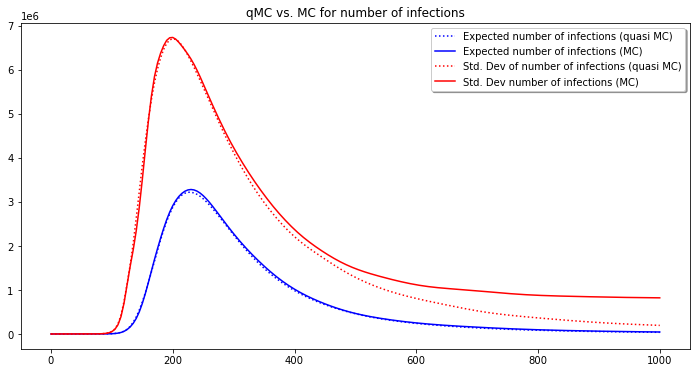

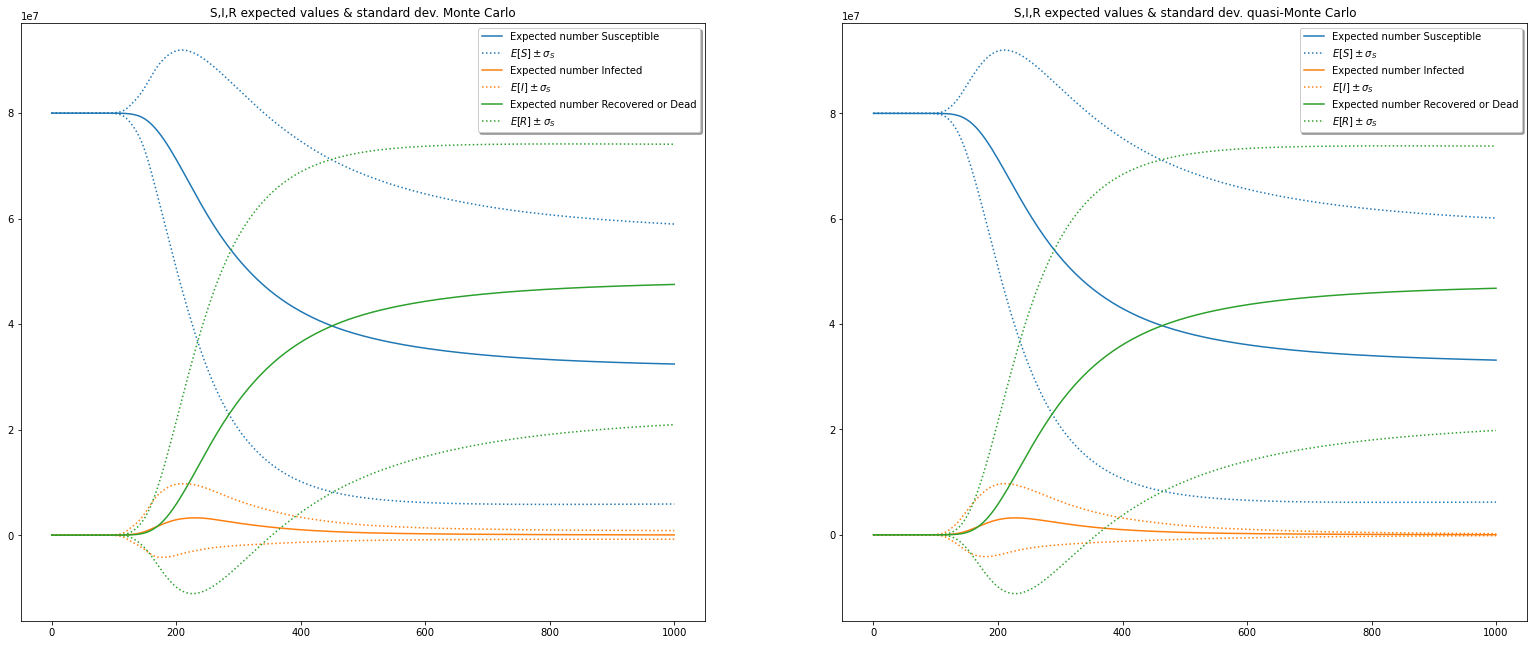

In [3]:
### (c) ###

#Numbers of samples 
M=10000

#Generate samples for MC and quasi-MC
q_bar = np.zeros(2,)
q_bar[0] = 1.2/9/N
q_bar[1] = 0.08
sigma_q = np.zeros((2,2))
sigma_q[0][0] = (0.04/N)**2
sigma_q[1][1] = 0.02**2

samples_MC=np.random.multivariate_normal(q_bar,sigma_q,M)

samples_qMC=sobol_seq.i4_sobol_generate(2, M)
samples_qMC[:,0] = norm.ppf(samples_qMC[:,0], loc=q_bar[0], scale=np.sqrt(sigma_q[0][0]))
samples_qMC[:,1] = norm.ppf(samples_qMC[:,1], loc=q_bar[1], scale=np.sqrt(sigma_q[1][1]))
mu_qMC = np.zeros((3,t_end+1))
mu_MC = np.zeros((3,t_end+1))
Sn_qMC = np.zeros((3,t_end+1))
Sn_MC = np.zeros((3,t_end+1))

result_i_qMC = np.zeros((3,t_end+1))
result_i_MC = np.zeros((3,t_end+1))
for i in range(M):
  result_i_qMC = Euler(f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,t_end,samples_qMC[i,0], samples_qMC[i,1])
  mu_old_qMC = mu_qMC
  mu_qMC = mu_old_qMC + (result_i_qMC-mu_old_qMC)/(i+1)
  Sn_qMC = Sn_qMC + (result_i_qMC - mu_old_qMC)*(result_i_qMC - mu_qMC)

  result_i_MC = Euler(f_I,f_S,f_R,t_0,I_0,S_0,R_0,h,t_end, samples_MC[i,0], samples_MC[i,1])
  mu_old_MC = mu_MC
  mu_MC = mu_old_MC + (result_i_MC-mu_old_MC)/(i+1)
  Sn_MC = Sn_MC + (result_i_MC - mu_old_MC)*(result_i_MC - mu_MC)


Sn_qMC = np.sqrt(Sn_qMC/M)
Sn_MC = np.sqrt(Sn_MC/M)

plt.figure(figsize=(12,6))
plt.plot(h*np.arange(t_end+1),mu_qMC[1,:],linestyle='dotted',color='blue', label = "Expected number of infections (quasi MC)")
plt.plot(h*np.arange(t_end+1),mu_MC[1,:],color='blue', label = "Expected number of infections (MC)")
plt.plot(h*np.arange(t_end+1),Sn_qMC[1,:],linestyle='dotted',color='red', label = "Std. Dev of number of infections (quasi MC)")
plt.plot(h*np.arange(t_end+1),Sn_MC[1,:],color='red', label = "Std. Dev number of infections (MC)")
plt.title("qMC vs. MC for number of infections")
_=plt.legend(shadow=True, fancybox=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(27,11))

ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:],label="Expected number Susceptible",color='C0')
ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:]+Sn_MC[0,:],linestyle='dotted',color='C0', label=r'$E[S] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[0,:]-Sn_MC[0,:],linestyle='dotted',color='C0')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:],label="Expected number Infected",color='C1')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:]+Sn_MC[1,:],linestyle='dotted',color='C1', label=r'$E[I] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[1,:]-Sn_MC[1,:],linestyle='dotted',color='C1')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:],label="Expected number Recovered or Dead",color='C2')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:]+Sn_MC[2,:],linestyle='dotted',color='C2', label=r'$E[R] \pm \sigma_S$')
ax[0].plot(h*np.arange(t_end+1),mu_MC[2,:]-Sn_MC[2,:],linestyle='dotted',color='C2')
ax[0].set_title("S,I,R expected values & standard dev. Monte Carlo")
_=ax[0].legend(shadow=True, fancybox=True)


ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:],label="Expected number Susceptible",color='C0')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:]+Sn_qMC[0,:],linestyle='dotted',color='C0', label=r'$E[S] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[0,:]-Sn_qMC[0,:],linestyle='dotted',color='C0')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:],label="Expected number Infected",color='C1')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:]+Sn_qMC[1,:],linestyle='dotted',color='C1', label=r'$E[I] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[1,:]-Sn_qMC[1,:],linestyle='dotted',color='C1')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:],label="Expected number Recovered or Dead",color='C2')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:]+Sn_qMC[2,:],linestyle='dotted',color='C2', label=r'$E[R] \pm \sigma_S$')
ax[1].plot(h*np.arange(t_end+1),mu_qMC[2,:]-Sn_qMC[2,:],linestyle='dotted',color='C2')
ax[1].set_title("S,I,R expected values & standard dev. quasi-Monte Carlo")
_=ax[1].legend(shadow=True, fancybox=True)

&nbsp;

---

##### Some literature on the SIR-Model:

[1] *Kermack, W. O., & McKendrick, A. G.* (1927). A contribution to the mathematical theory of epidemics. Proceedings of the royal society of london. Series A, Containing papers of a mathematical and physical character, 115(772), 700-721.

[2] *Brauer, F.* (2005). The Kermack–McKendrick epidemic model revisited. Mathematical biosciences, 198(2), 119-131.

[3] *Satsuma, J., Willox, R., Ramani, A., Grammaticos, B., & Carstea, A. S.* (2004). Extending the SIR epidemic model. Physica A: Statistical Mechanics and its Applications, 336(3-4), 369-375.

[4] *Nesteruk, I.* (2020). SIR-simulation of Corona pandemic dynamics in Europe. medRxiv.


###### &nbsp;

**EXERCISE 3)**

Assume that we have a sequence of random numbers $(Z_l)_{l\in \mathbb{N}}$ with $Z = \lim_{l \rightarrow \infty} Z_l.^{[1]}$ We wish to approximate $E[Z]$ with Multi-Level Monte Carlo (MLMC) by sampling from finitely many $Z_l$ with $l = 0,...,L$. The MLMC estimator Y is given by

$$ Y = \sum_{l=0}^L Y_l, \quad Y_l = N_l^{-1}\sum_{n=1}^{N_l}(Z_l^{(l,n)}-Z^{(l-1,n)})$$

with $Z_{-1} =0$.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Show that 

$$ E[Y] = E[Z_L], \quad \text{Var}[Y] = \sum_{l=0}^L N_l^{-1}V_l, \text{ with } V_l = \text{Var}[Z_l-Z_{l-1}]. $$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Show that the mean square error (MSE) of the MLMC estimator $Y$ with maximum level $L$ is given by 

$$ MSE = E[(Y-E[Z])^2] = \text{Var}[Y] + (E[Y]-E[Z])^2.$$

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;     Interpret the two terms on the right hand side by using the results from part (a). What is the difference to the lecture?                         
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  How does the choice of $L, N_0, ... , N_L$ affect each term?

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) We now want to choose the maximum level $L$ as well as the number of samples for each level such that $MSE \leq \epsilon^2$                             
&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  while the costs are minimal. Assume that the given sequence fulfills

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (i) $\vert Z_l-Z\vert \leq c_1 2^{-\alpha l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (ii) $V_l \leq c_2 2^{-\beta l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (iii) $K_l \leq c_3 2^{\gamma l}$,

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  with costs $K_l$. Show that the optimal parameters $L, N_0, ..., N_L$ in terms of $\alpha, \beta, \gamma, c_{1,2,3} $ are

$$L = \left\lceil{-\frac{1}{\alpha}\log_2\left(\frac{\varepsilon}{\sqrt{2}c_1}\right)}\right\rceil, \quad N_l = \left\lceil{\frac{2c_2}{\varepsilon^2}2^{-(\gamma+\beta)l/2}\sum_{k = 0}^{L} 2^{(\gamma-\beta)k/2}}\right\rceil.$$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  **Hint:** Start with $\text{Var}[Y]=\varepsilon^2/2$ and $(E[Y]-E[Z])^2=\varepsilon^2/2$ to ensure $MSE=\varepsilon^2$.

----
$^{[1]}$ You can think of $Z_l$ as an approximation of an ODE solution resulting from a numerical discretization with refinement level $l$. 

&nbsp;

**EXERCISE 4)**

We now want to use the results from Exercise 3 in an application. For this, run the code below and consider questions (a)-(c).

Let $Z=\mathcal{u}(t_{end},X)$, where $X$ is uniformly distributed in [0,1] and $\mathcal{u}$ is the solution of

&nbsp;

$$
 \mathcal{u'} = -\lambda \mathcal{u}, \;\:\: \mathcal{u}(t=0,X) = X,
$$

&nbsp;

The sequence $Z_l$ is given by an Euler method

&nbsp;

$$
\mathcal{u_l}(t_{n+1}) = \mathcal{u_l}(t_{n}) - \Delta t_c 2^{-l} \lambda \mathcal{u_l}(t_{n}), \;\:\: \mathcal{u_l}(0,X) = X.
$$

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Determine $\alpha, \beta, \gamma$ and estimate $c_1,c_2,c_3$ from Exercise 3 c).
                             
 &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **Hint:** Use a Taylor expansion to estimate $c_1,c_2,c_3$.

 &nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Look at the code and add the parameters for this problem.

 &nbsp;
 
 &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) Think of advantages and disadvantages of MLMC. Can we obtain the expected value with given accuracy if the problem parameters are not known?

In [11]:
#Define required functions

#Function to determine sequence Zl
def ForwardEuler (l,tEnd,dtCoarse,X,lambda_c):
  if l==-1:
    Pl = 0
    cost = 0
    return Pl, cost
  
  dt = dtCoarse*2**(-l)
  Nt = round(tEnd/dt)

  u=X

  for i in range(1,Nt+1):
    uNew = u -dt*lambda_c*u
    u=uNew

  Pl = u
  cost = Nt

  return Pl, cost

### Multi-Level Monte Carlo Estimator ###
def MCLevelEstimator (l, Nl, tEnd, dtCoarse, lambda_c):
  Yl=0
  for i in range(1,Nl+1):
    X=np.random.uniform(0,1,(1,1))
    ZlM, costLM = ForwardEuler (l-1,tEnd,dtCoarse,X,lambda_c)
    Zl, costL = ForwardEuler (l,tEnd,dtCoarse,X,lambda_c)
    Yl = Yl + Zl -ZlM

  Yl = (1/Nl)*Yl
  cost= (costLM + costL)*Nl 

  return Yl, cost

def MLMCEstimator (alpha, beta, gamma, c1, c2, c3, epsilon, tEnd, lambda_c):
  dtCoarse=1/lambda_c

  #Compute L according to Exercise 2c)
  L = math.ceil (math.log2(epsilon/(np.sqrt(2)*c1))/(-alpha))
  print("Max number of levels is {0}".format(L))

  #Compute number of MC samples for all levels according to Exercise 2c)
  N= np.zeros((L+1,1))
  sumL= sum(2**((gamma-beta)*np.arange(L+1)/2))

  for l in range(L+1):
    N[l]=math.ceil(2*c2/(epsilon**2)*2**(-0.5*(gamma+beta)*l)*sumL)
  
  Y=0
  cost=0

  for l in range(L+1):
    print("Computing level {0}".format(l))
    print("Number MC samples is {0}".format(N[l]))
    Yl, costL = MCLevelEstimator(l,int(N[l]),tEnd,dtCoarse,lambda_c)
    Y = Y + Yl
    cost = cost + costL
  
  return Y, cost, L


### Monte Carlo Estimator ###
def MCEstimator (L, N, tEnd, dt, lambda_c):
  Yl = 0
  for i in range(1,N+1):
    Z=np.random.uniform(0,1,(1,1))
    Pl , costL = ForwardEuler (L,tEnd,dt,Z,lambda_c)
    Yl = Yl + Pl
  
  Yl= (1/N)*Yl
  cost = costL*N

  return Yl, cost

In [13]:
#Set parameters and compare methods MLMC and MC

#Problem settings
tEnd = 2
lambda_c = 0.5
dtCoarse = 1/lambda_c

#Desired level of accuracy
epsilon = 0.005

#-----------MLMC------------#
#Properties of numerical discretization
#Convergence/growth parameters
alpha = 1
beta = 2
gamma = 1
#Constants
c1 = 0.5*lambda_c**2*tEnd*dtCoarse
c2 = (0.5*lambda_c**2*tEnd*dtCoarse)**2
c3 = 4*(tEnd/dtCoarse)

#Approximate expectation value with MLMC & return cost and max. refinement level
Y, cost, L = MLMCEstimator (alpha, beta, gamma, c1, c2, c3, epsilon, tEnd, lambda_c)

#------------MC-------------#
#Estimate max. samples to reach desired accuracy with MC
V0 = c1**2
nMC = math.ceil(V0/epsilon**2)

print("Number of MC samples is {0}".format(nMC))

YMC, costMC = MCEstimator (L,nMC, tEnd, dtCoarse, lambda_c)

#----------Results----------#
print("MC error is {0}".format(abs(0.5*math.exp(-lambda_c*tEnd)-YMC)))
print("MLMC error is {0}".format(abs(0.5*math.exp(-lambda_c*tEnd)-Y)))

if costMC/cost > 1:
  print("MC is {0} times more expensive than MLMC".format(costMC/cost))
else:
  print("MLMC is {0} times more expensive than MC".format(cost/costMC))

Max number of levels is 8
Computing level 0
Number MC samples is [65267.]
Computing level 1
Number MC samples is [23076.]
Computing level 2
Number MC samples is [8159.]
Computing level 3
Number MC samples is [2885.]
Computing level 4
Number MC samples is [1020.]
Computing level 5
Number MC samples is [361.]
Computing level 6
Number MC samples is [128.]
Computing level 7
Number MC samples is [46.]
Computing level 8
Number MC samples is [16.]
Number of MC samples is 10000
MC error is [[0.00105202]]
MLMC error is [[0.00077538]]
MC is 8.91548054788414 times more expensive than MLMC


&nbsp;

### **Additional Exercises**



&nbsp;

**EXERCISE 5)**

Use the Chebyshev's Lemma to prove the Weak Law of Large Numbers.

&nbsp;

*Chebyshev's Lemma:* 

Let $X$ be a random variable with mean $\mu$ and variance $\sigma^2$. Then for any real number $r$ we have 
&nbsp;

$$ P(| X - \mu | \geq r\sigma) \leq \frac{1}{r^2}.$$

&nbsp;

*The Weak Law of Large Numbers:*

Let $X_1,X_2,...$ be an infinite sequence of iid random variables with finite mean $E(X_1) = E(X_2) = ... = \mu$ and finite variance $Var(X_1) = Var(X_2) = ... = \sigma^2$, and define the sequence of means 
&nbsp;

$$ \bar X_n = \frac{1}{n}(X_1 + ... + X_n).$$
&nbsp;

Show that, as $n \rightarrow \infty$, $\bar X_n$ converges to $\mu$ in probability, i.e. for every $\epsilon > 0$

&nbsp;

$$ \lim_{n \to \infty} P(|\bar X_n -\mu | \geq \epsilon) = 0.$$

&nbsp;

**EXERCISE 6)**

Consider the random ODE

$$ \frac{du}{dt}(t,Z) = \alpha(Z) u(t,Z), \;\;\; u(0,Z) = \beta(Z).$$

Assume that $\alpha$ is uniformly distributed on the interval $[a,b]$, and that $\beta$ is Gaussian normal distributed.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (a) Compute the expected value and the variance of $u(t,Z)$ at a fixed time $t$.

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (b) Use Python to approximate the expectation value of $u(t,Z)$ by Monte-Carlo sampling.         

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  How does the approximation behave with the sample size?

&nbsp;

&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  (c) Approximate also the standard deviation of $u(t,Z)$.